# Attention Is All You Need
by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin

Summary by Georgi Petrov, Course Deep Learning, SoftUni, 2023

## Abstract

The paper introduces a novel neural network architecture called the "Transformer." Unlike traditional sequence transduction models that rely on complex recurrent or convolutional neural networks with encoders and decoders, the Transformer is based solely on attention mechanisms. This eliminates the need for recurrence and convolution, making it more parallelizable and faster to train.

The paper also highlights that the Transformer architecture generalizes well to other tasks, such as English constituency parsing, even when limited training data is available. Overall, the Transformer represents a promising and efficient approach to sequence transduction tasks. [13], [7], [35], [2], [5], [38], [24], [15], [21], [32], [2], [19], [27]

## Introduction and Background

The supremacy of recurrent neural networks (RNNs), particularly LSTM and GRU, in sequence modeling, language modeling, and machine translation is undisputed. However, while these models excel, they suffer from sequential processing limitations, hindering parallelization and thus performance.

Attention mechanisms have been crucial for capturing dependencies in sequences, usually combined with recurrent networks.

The newly proposed architecture is Transformer model, a departure from recurrent models. It relies solely on attention mechanisms to model global dependencies, allowing for efficient parallelization. Remarkably, the Transformer achieves state-of-the-art translation quality with just twelve hours of training on eight P100 GPUs.

The number of operations needed to capture dependencies between distant positions in existing models increases with distance, making it challenging to learn such dependencies.

In contrast, the Transformer model minimizes this issue by performing a constant number of operations for relating signals between positions, though it sacrifices some effective resolution due to averaging attention-weighted positions. To address this, the paper introduces Multi-Head Attention. 

Self-attention is an attention mechanism used to relate different positions in a sequence for computing a representation. It has proven successful in various tasks like reading comprehension and summarization. While end-to-end memory networks also use attention mechanisms, the Transformer stands out as the first transduction model relying solely on self-attention for computing representations without using sequential RNNs or convolution. The subsequent sections describe the Transformer, its motivation for self-attention, and its advantages over other models. [16], [18], [9], [12], [4], [27], [28], [22], [34], [17], [18], [9]

## Model Architecture

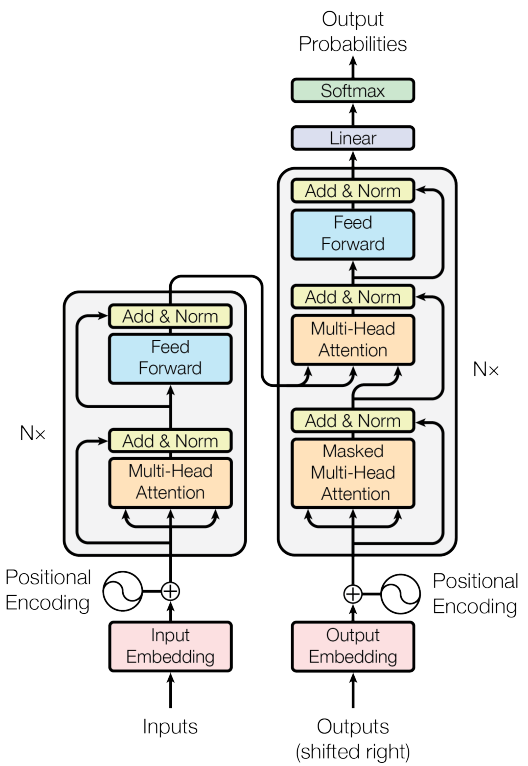

Most competitive neural sequence transduction models follow an encoder-decoder structure [5, 2, 35]. In the Transformer architecture, the encoder maps input symbols to continuous representations, while the decoder generates output symbols one at a time in an auto-regressive manner [10].

The Transformer utilizes stacked self-attention and fully connected layers for both the encoder and decoder. The encoder consists of multiple identical layers, each comprising a multi-head self-attention mechanism and a position-wise fully connected feed-forward network. Residual connections and layer normalization are applied to these sub-layers. The decoder shares a similar structure but also includes a sub-layer for multi-head attention over the encoder's output. Masking ensures that predictions in the decoder depend only on known outputs from previous positions.

### Attention

The attention function takes a query and a collection of key-value pairs as inputs, all represented as vectors. It computes an output by calculating a weighted sum of the values. These weights are determined based on the compatibility between the query and each key.

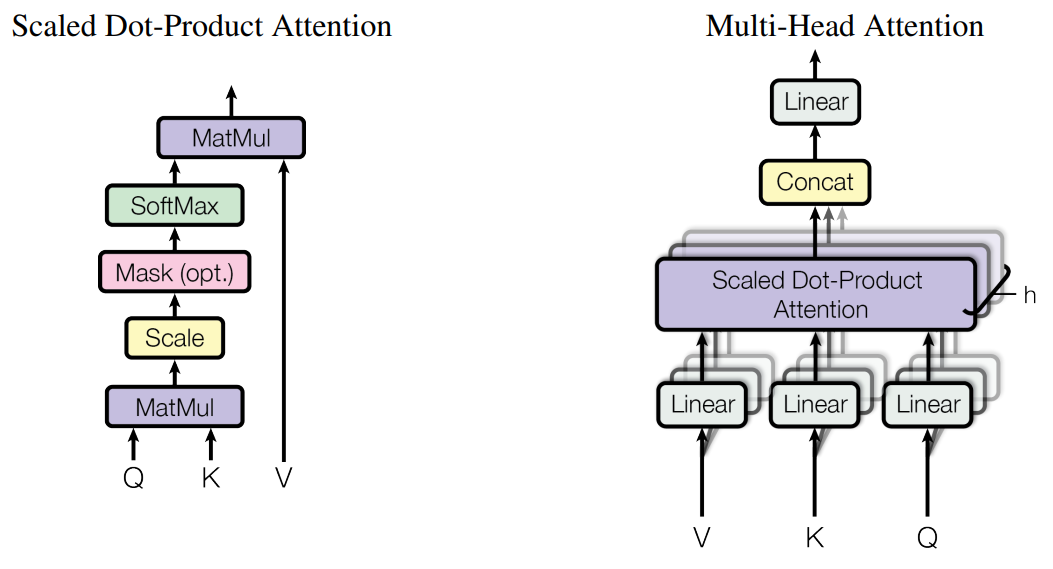

Scaled Dot-Product Attention mechanism operates on queries, keys, and values of different dimensions ($d_k$ and $d_v$). The process involves computing dot products between queries and keys, scaling by $\sqrt{d_k}$, and applying a softmax function to obtain weights for values. It's performed on sets of queries, keys, and values packed into matrices for efficiency. This mechanism is compared to additive attention, with dot-product attention being more efficient, especially for large $d_k$ values.

$$ Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V $$

Instead of a single attention mechanism, the model uses Multi-Head Attention that linearly projects queries, keys, and values multiple times using learned projections. Each projected version is used to perform the attention function in parallel, resulting in concatenated and projected output values. This approach allows the model to attend to different information from various representation subspaces simultaneously, improving performance. The work employs 8 parallel attention layers, each with reduced dimensions $ d_k = d_v = d_{model} / h = 64 $, similar in computational cost to single-head attention with full dimensionality.

$$ MultiHead(Q,K,V) = Concat(head_1,...,head_h)W^O $$

where

$$ head_i = Attention(QW_{i}^{Q}, KW_{i}^{K}, VW_{i}^{V}) $$

The Transformer uses multi-head attention in three ways:

* In "encoder-decoder attention" layers, it allows each decoder position to consider all input positions. [38, 2, 9]
* In the encoder, self-attention layers enable each encoder position to attend to the preceding layer.
* In the decoder, self-attention layers allow each decoder position to attend to prior decoder positions while preventing leftward information flow to maintain auto-regression.

There is a need for preserving the order of tokens in a sequence within a model that lacks recurrence or convolution. To achieve this, the model uses *positional encodings* added to the input embeddings at the encoder and decoder stacks. These positional encodings, having the same dimension as the embeddings, provide information about the relative or absolute positions of tokens in the sequence. The choice of positional encodings can be learned or fixed.

#### Complexity and Performance Analysis

Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations for different layer types. $n$ is the sequence length, $d$ is the representation dimension, $k$ is the kernel size of convolutions and $r$ the size of the neighborhood in restricted self-attention.


| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |
| :---------- | :----------: | :----------: | :----------: |
| Self-Attention | $O(n^2 \cdot d)$ | $O(1)$ | $O(1)$ |
| Recurrent | $O(n \cdot d^2)$ | $O(n)$ | $O(n)$ |
| Convolutional | $O(k \cdot n \cdot d^2)$ | $O(1)$ | $O(log_k(n))$ | 
| Self-Attention (restricted) | $O(r \cdot n \cdot d)$ | $O(1)$ | $O(n/r)$ | 

#### Positional Encoding

There are many choices of positional encodings, learned and fixed [9]. In this model, sine and cosine functions of different frequencies are used:

$$ PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}}) $$
$$ PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}}) $$

where $pos$ is the position and $i$ is the dimension.

## Training

The model was trained on the WMT 2014 English-German dataset, which contains about 4.5 million sentence pairs. Byte-pair encoding was used for text encoding with a shared vocabulary of approximately 37,000 tokens. For English-French, a larger dataset was used, consisting of 36 million sentences and a 32,000 word-piece vocabulary. Batching was done based on approximate sequence length, with each training batch containing around 25,000 source tokens and 25,000 target tokens. [3] [38]

The training was conducted on a single machine equipped with 8 NVIDIA P100 GPUs. For the base models, training took about 0.4 seconds per step, with 100,000 steps (12 hours) of training. Larger models had a step time of 1.0 seconds and were trained for 300,000 steps (3.5 days).

The team used the Adam optimizer [20] with $ β_1 = 0.9 $, $ β_2 = 0.98 $ and $ϵ = 10^{−9} $. 

### Regularization

Residual dropout is applied to the output of each sub-layer before normalization, and dropout is also applied to the sums of embeddings and positional encodings in both the encoder and decoder stacks. The dropout rate used for the base model is $ P_{drop} = 0.1 $.

Additionally, during training, label smoothing with a value of $ϵ_{ls} = 0.1$ is employed. While this may hurt perplexity, it enhances accuracy and BLEU score.

## Results

Table 2: The Transformer achieves better BLEU scores than previous state-of-the-art models on the English-to-German and English-to-French newstest2014 tests at a fraction of the training cost.

| Model                    | BLEU  |        | Training Cost (FLOPs) |       |
|--------------------------|-------|--------|------------------------|-------|
|                          | EN-DE | EN-FR  | EN-DE                  | EN-FR |
| ByteNet [18]             | 23.75 |        |                        |       |
| Deep-Att + PosUnk [39]   |       | 39.2   |                        | $1.0 \cdot 10^{20}$ |
| GNMT + RL [38]           | 24.6  | 39.92  | $2.3 \cdot 10^{19}$    | $1.4 \cdot 10^{20}$ |
| ConvS2S [9]              | 25.16 | 40.46  | $9.6 \cdot 10^{18}$    | $1.5 \cdot 10^{20}$ |
| MoE [32]                 | 26.03 | 40.56  | $2.0 \cdot 10^{19}$    | $1.2 \cdot 10^{20}$ |
| Deep-Att + PosUnk Ensemble [39]  |        | 40.4     |             | $8.0 \cdot 10^{20}$ |
| GNMT + RL Ensemble [38]  | 26.30 | 41.16  | $1.8 \cdot 10^{20}$    | $1.1 \cdot 10^{21}$ |
| ConvS2S Ensemble [9]     | 26.36 | __41.29__  | $7.7 \cdot 10^{19}$ | $1.2 \cdot 10^{21}$ |
| Transformer (base model) | 27.3  | 38.1   | <b> $ 3.3 \cdot 10^{18} $  </b>   | <b> $ 3.3 \cdot 10^{18} $  </b> |
| Transformer (big)        | __28.4__  | __41.8__   | $ 2.3 \cdot 10^{19} $ | $2.3 \cdot 10^{19}$ |

The big Transformer model outperforms previously reported models on the WMT 2014 English-to-German translation task by achieving a state-of-the-art BLEU score of 28.4. Training took 3.5 days on 8 P100 GPUs.

The base model also surpasses previously published models and ensembles while requiring a fraction of the training cost.

On the WMT 2014 English-to-French translation task, the big model achieves a BLEU score of 41.0, outperforming previous single models at significantly lower training cost.

Different dropout rates were used for English-to-German and English-to-French tasks.

Averaging multiple checkpoints improved model performance.

Beam search with specific hyperparameters was employed during inference.

Table 2 provides a summary of results and cost comparisons with other model architectures in the literature, estimated in terms of floating point operations used for training.

###  English Constituency Parsing

This task has structural constraints and long output sequences. The model, trained with various datasets, demonstrates strong performance without task-specific tuning. It outperforms previous models, except for the Recurrent Neural Network Grammar, and even surpasses the BerkeleyParser when trained only on a smaller dataset of 40K sentences. [25, 37, 37, 29, 8]

## Conclusion

This work introduces the Transformer, a sequence transduction model that relies entirely on attention mechanisms, replacing recurrent layers in encoder-decoder architectures. The Transformer achieves faster training compared to recurrent or convolutional-based models and sets new state-of-the-art results on translation tasks. Future research will explore applying attention-based models to various tasks, handling different modalities, and improving generation efficiency. The code for these models is available on GitHub at https://github.com/tensorflow/tensor2tensor.

## Replicating Code Examples

### Official Code Examples

The official GitHub repo from the original paper is located here: https://github.com/tensorflow/tensor2tensor

The project refers to the following Google Colab notebook: https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb

Unfortunately, the notebook uses TensorFlow 1.x which is not supported in Google Colab anymore. I tried to convert the API to 2.x, but this failed with multiple errors. Then I tried to run the notebook in a local environment with the right dependencies installed in an Anaconda environment, but all my attempts failed one way or another. Eventually, given unlimited time, running the notebook would be possible. But given the limited time I'm willing to spend on this task, this proved unsuccessful.

As I side note, I really wanted to read, try to understand and summarize this exact paper. I was aware that the code might be obsolete and might not work years later. As I consider this paper summary the theoretical one, I will make sure that for my practical paper summary running the code is possible before I make the actual summary.

### Unofficial Code Examples

I ran the following two code examples that are based on the discussed paper:

Example 1 (original): https://colab.research.google.com/github/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/transformers/basic/autoregressive_experiment.ipynb

Example 1 (my Google Drive copy with outputs): https://colab.research.google.com/drive/179ueMiwl0SC7kLooBrngTl4JioGs4RLw?usp=sharing

Example 2 (original): https://colab.research.google.com/github/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/transformers/basic/autoregressive_experiment.ipynb

Example 2 (my Google Drive copy with outputs): https://colab.research.google.com/drive/13HA5A-ba0oMJTbDyJx1k_zRBjUuaysix?usp=sharing

It is not the exact code from the original paper, but is in my humble opinion a good enough example.

## References

[1] Jimmy Lei Ba, Jamie Ryan Kiros, and Geoffrey E Hinton. Layer normalization. arXiv preprintarXiv:1607.06450, 2016.

[2] Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. Neural machine translation by jointlylearning to align and translate. CoRR, abs/1409.0473, 2014.

[3] Denny Britz, Anna Goldie, Minh-Thang Luong, and Quoc V. Le. Massive exploration of neuralmachine translation architectures. CoRR, abs/1703.03906, 2017.

[4] Jianpeng Cheng, Li Dong, and Mirella Lapata. Long short-term memory-networks for machinereading. arXiv preprint arXiv:1601.06733, 2016.

[5] Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Fethi Bougares, Holger Schwenk,and Yoshua Bengio. Learning phrase representations using rnn encoder-decoder for statisticalmachine translation. CoRR, abs/1406.1078, 2014.

[6] Francois Chollet. Xception: Deep learning with depthwise separable convolutions. arXivpreprint arXiv:1610.02357, 2016.

[7] Junyoung Chung, Çaglar Gülçehre, Kyunghyun Cho, and Yoshua Bengio. Empirical evaluationof gated recurrent neural networks on sequence modeling. CoRR, abs/1412.3555, 2014.

[8] Chris Dyer, Adhiguna Kuncoro, Miguel Ballesteros, and Noah A. Smith. Recurrent neuralnetwork grammars. In Proc. of NAACL, 2016.

[9] Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolutional sequence to sequence learning. arXiv preprint arXiv:1705.03122v2, 2017.

[10] Alex Graves. Generating sequences with recurrent neural networks. arXiv preprintarXiv:1308.0850, 2013.

[11] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. In Proceedings of the IEEE Conference on Computer Vision and PatternRecognition, pages 770–778, 2016.

[12] Sepp Hochreiter, Yoshua Bengio, Paolo Frasconi, and Jürgen Schmidhuber. Gradient flow inrecurrent nets: the difficulty of learning long-term dependencies, 2001.

[13] Sepp Hochreiter and Jürgen Schmidhuber. Long short-term memory. Neural computation,9(8):1735–1780, 1997.

[14] Zhongqiang Huang and Mary Harper. Self-training PCFG grammars with latent annotationsacross languages. In Proceedings of the 2009 Conference on Empirical Methods in NaturalLanguage Processing, pages 832–841. ACL, August 2009.

[15] Rafal Jozefowicz, Oriol Vinyals, Mike Schuster, Noam Shazeer, and Yonghui Wu. Exploringthe limits of language modeling. arXiv preprint arXiv:1602.02410, 2016.

[16] Łukasz Kaiser and Samy Bengio. Can active memory replace attention? In Advances in NeuralInformation Processing Systems, (NIPS), 2016.

[17] Łukasz Kaiser and Ilya Sutskever. Neural GPUs learn algorithms. In International Conferenceon Learning Representations (ICLR), 2016.

[18] Nal Kalchbrenner, Lasse Espeholt, Karen Simonyan, Aaron van den Oord, Alex Graves, and Koray Kavukcuoglu. Neural machine translation in linear time. arXiv preprint arXiv:1610.10099v2, 2017.

[19] Yoon Kim, Carl Denton, Luong Hoang, and Alexander M. Rush. Structured attention networks.In International Conference on Learning Representations, 2017.

[20] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In ICLR, 2015.

[21] Oleksii Kuchaiev and Boris Ginsburg. Factorization tricks for LSTM networks. arXiv preprintarXiv:1703.10722, 2017.

[22] Zhouhan Lin, Minwei Feng, Cicero Nogueira dos Santos, Mo Yu, Bing Xiang, BowenZhou, and Yoshua Bengio. A structured self-attentive sentence embedding. arXiv preprintarXiv:1703.03130, 2017.

[23] Minh-Thang Luong, Quoc V. Le, Ilya Sutskever, Oriol Vinyals, and Lukasz Kaiser. Multi-tasksequence to sequence learning. arXiv preprint arXiv:1511.06114, 2015.

[24] Minh-Thang Luong, Hieu Pham, and Christopher D Manning. Effective approaches to attentionbased neural machine translation. arXiv preprint arXiv:1508.04025, 2015.

[25] Mitchell P Marcus, Mary Ann Marcinkiewicz, and Beatrice Santorini. Building a large annotated corpus of english: The penn treebank. Computational linguistics, 19(2):313–330, 1993.

[26] David McClosky, Eugene Charniak, and Mark Johnson. Effective self-training for parsing. In Proceedings of the Human Language Technology Conference of the NAACL, Main Conference, pages 152–159. ACL, June 2006.

[27] Ankur Parikh, Oscar Täckström, Dipanjan Das, and Jakob Uszkoreit. A decomposable attention model. In Empirical Methods in Natural Language Processing, 2016.

[28] Romain Paulus, Caiming Xiong, and Richard Socher. A deep reinforced model for abstractive summarization. arXiv preprint arXiv:1705.04304, 2017.

[29] Slav Petrov, Leon Barrett, Romain Thibaux, and Dan Klein. Learning accurate, compact,and interpretable tree annotation. In Proceedings of the 21st International Conference onComputational Linguistics and 44th Annual Meeting of the ACL, pages 433–440. ACL, July2006.

[30] Ofir Press and Lior Wolf. Using the output embedding to improve language models. arXivpreprint arXiv:1608.05859, 2016.

[31] Rico Sennrich, Barry Haddow, and Alexandra Birch. Neural machine translation of rare wordswith subword units. arXiv preprint arXiv:1508.07909, 2015.

[32] Noam Shazeer, Azalia Mirhoseini, Krzysztof Maziarz, Andy Davis, Quoc Le, Geoffrey Hinton,and Jeff Dean. Outrageously large neural networks: The sparsely-gated mixture-of-expertslayer. arXiv preprint arXiv:1701.06538, 2017.

[33] Nitish Srivastava, Geoffrey E Hinton, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov. Dropout: a simple way to prevent neural networks from overfitting. Journal of MachineLearning Research, 15(1):1929–1958, 2014.

[34] Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, and Rob Fergus. End-to-end memorynetworks. In C. Cortes, N. D. Lawrence, D. D. Lee, M. Sugiyama, and R. Garnett, editors,Advances in Neural Information Processing Systems 28, pages 2440–2448. Curran Associates,Inc., 2015.

[35] Ilya Sutskever, Oriol Vinyals, and Quoc VV Le. Sequence to sequence learning with neuralnetworks. In Advances in Neural Information Processing Systems, pages 3104–3112, 2014.

[36] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna.Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.

[37] Vinyals & Kaiser, Koo, Petrov, Sutskever, and Hinton. Grammar as a foreign language. InAdvances in Neural Information Processing Systems, 2015.

[38] Yonghui Wu, Mike Schuster, Zhifeng Chen, Quoc V Le, Mohammad Norouzi, WolfgangMacherey, Maxim Krikun, Yuan Cao, Qin Gao, Klaus Macherey, et al. Google’s neural machinetranslation system: Bridging the gap between human and machine translation. arXiv preprintarXiv:1609.08144, 2016.

[39] Jie Zhou, Ying Cao, Xuguang Wang, Peng Li, and Wei Xu. Deep recurrent models withfast-forward connections for neural machine translation. CoRR, abs/1606.04199, 2016.

[40] Muhua Zhu, Yue Zhang, Wenliang Chen, Min Zhang, and Jingbo Zhu. Fast and accurateshift-reduce constituent parsing. In Proceedings of the 51st Annual Meeting of the ACL (Volume1: Long Papers), pages 434–443. ACL, August 2013.